In [93]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Custom GTZAN Datasets

In this notebook we have collected all the datasets that we will use for our neural network

# Custom Transforms for our dataset

This is the trasform to normalize the data in the csv files

In [94]:
# This is a custom transform to normalize the features
class CustomNormalize:
    def __init__(self, mean, std):
        self.mean = mean.view(1, -1, 1)
        self.std = std.view(1, -1, 1)

    def __call__(self, tensor):
        return (tensor - self.mean) / self.std

This is the trasform to change the labels from strings to one hot vectors

In [95]:
class LabelToOneHotTransform:
    def __init__(self, label_set):
        # Map each of the first 10 letters of the alphabet to an index
        self.label_to_index = {label: index for index, label in enumerate(label_set)}

    def __call__(self, label):
        # Initialize a one-hot encoded tensor of size 10 (for 10 classes)
        one_hot = torch.zeros(10, dtype=torch.float)
        # Set the appropriate position to 1 based on the label index
        label_index = self.label_to_index[label]
        one_hot[label_index] = 1.0
        return one_hot

## Spectrogram Dataset

This is the dataset composed of spectogram images

In [116]:
class GTZANSpectogramDataset(Dataset):
    def __init__(self, features_file, img_dir, transform=None, target_transform=None):
        """
        Args:
            features_file (string): Path to the csv file with features.
            img_dir (string): Directory with all the spectrogram images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        # We drop the feature related to the length of the audio file
        self.features_frame = pd.read_csv(features_file).drop('length', axis=1)         
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform


    def __len__(self):
        return len(self.features_frame)


    def __getitem__(self, idx):
        # Load image data
        while True:
            try:
                img_name = self.generate_gtzan_full_img_name(self.features_frame.iloc[idx, 0], self.img_dir)
                image_rgba = Image.open(img_name)
                break
            except:
                # We skip the image that we can't open
                #print(f"Error opening image {img_name}")  # 'jazz.00054.png' is missing
                idx += 1
        image = image_rgba.convert("L")    # We convert the img to greyscale

        # Load label
        label = self.features_frame.iloc[idx, -1]


        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label


    def generate_gtzan_full_img_name(self, original_img_name, img_dir):
        """ 
            The file name in the csv is 'reggae.00019.wav', 
            we neet to change it to '\\reggae\\reggae00019.png'
        """
        # We have to change the extension of the file
        img_file_name = original_img_name.replace('.wav', '.png')
        # To get the name of the folder we need to remove '.png' and the identifiers numbers (ex '.00000)'
        img_folder_name = img_file_name[:-10]    
        # Now we need to remove the '.' between 'reggae.00019'    
        img_file_name = img_file_name[:-10] + img_file_name[-9:]    
        # Now we can create the full path   
        img_name = os.path.join(img_dir, img_folder_name, img_file_name)

        return img_name

### Testing the dataset

In [120]:
labels = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock']
# Example usage of the transform
label_transform = LabelToOneHotTransform(labels)


# This transform also normalizes
transform_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.466],            
                         std=[0.459])
])


# Path to the csv file with the features
features_file = 'Data\\features_30_sec.csv'
img_dir = 'Data\\images_original'

# Create the dataset
gtzan_dataset = GTZANSpectogramDataset(features_file=features_file, img_dir=img_dir, transform=transform_norm, target_transform=label_transform)

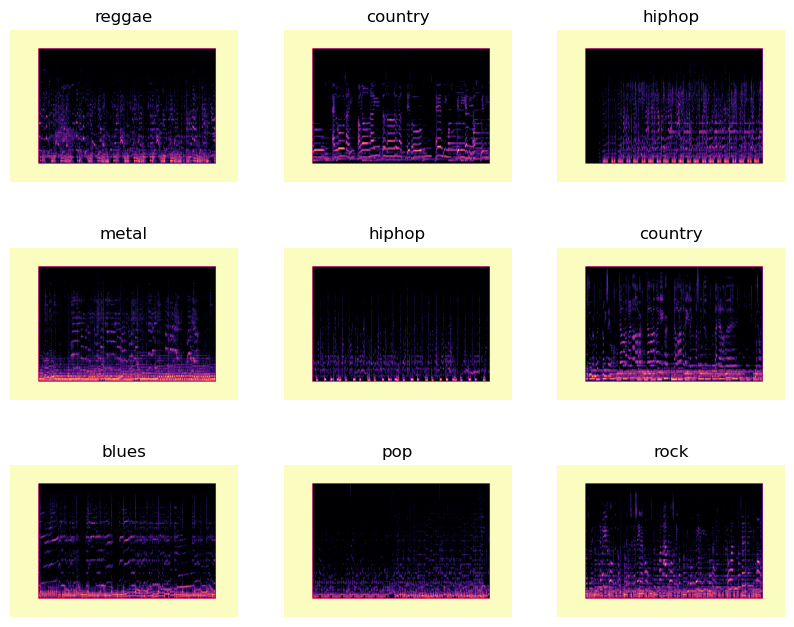

In [121]:
original_labels = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock']


# Testing the dataset
figure = plt.figure(figsize=(10, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(gtzan_dataset), size=(1,)).item()      # This line generates a random tensor with 1 element and the converts it to scalar
    # sample_idx = i
    img, label = gtzan_dataset[sample_idx]                                # 'training_data[sample_idx]' returns a tuple!

    figure.add_subplot(rows, cols, i)
    plt.title(original_labels[np.argmax(label)])
    plt.axis("off")
    
    # The image is a [1, 288, 432] tensor, the first dimension is the batch size
    plt.imshow(img[0], cmap="magma")

plt.show()

### Testing the Dataloader

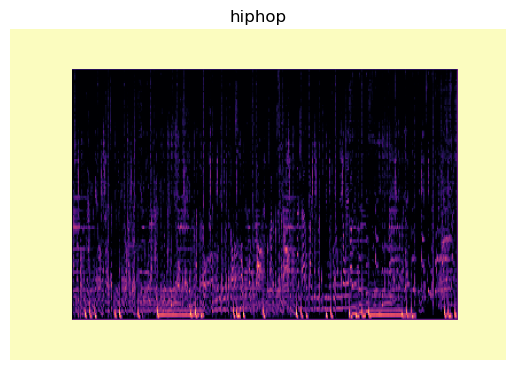

In [123]:
# Create a DataLoader
batch_size = 4
shuffle = True
num_workers = 0           # values over 0 means that it uses more cores to load the data

dataloader = DataLoader(gtzan_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)



# Example of using the dataloader in a training loop (we plot only the first image in the batch)
for i, data in enumerate(dataloader):
    images, labels = data
    img = images[0]
    plt.imshow(img[0], cmap="magma")
    plt.title(original_labels[np.argmax(labels[0])])
    plt.axis("off")
    break

### Computing the mean and std of spectogram data

This step is important because spectogram have a different distribution then normal images

In [5]:
def compute_mean_std(features_file, img_dir):
    # Basic Transform
    transform = transforms.Compose([transforms.ToTensor()])

    # Create the dataset
    dataset = GTZANSpectogramDataset(features_file=features_file, img_dir=img_dir, transform=transform)
    
    # Use a Batch size of 1
    dataloader = DataLoader(dataset, batch_size=1, num_workers=0, shuffle=False)

    # Initial values
    mean = 0.0
    mean_sq = 0.0
    nb_samples = 0
    
    for i, data in enumerate(dataloader):
        images, labels = data
        
        # The image has this shape :(batch_size, RGB_channels, height, width)
        # print(images.shape)
        
        # Here we select the image from the batch
        image = images[0][0]
        # plt.imshow(image, cmap="magma")

        # We sum the mean and std of each channel
        mean += image.mean(dim=(0, 1))
        mean_sq += (image**2).mean(dim=(0, 1))          
        nb_samples += 1

    print(f"Number of samples: {nb_samples}")

    # Computing the mean and the mean of the squares
    mean /= nb_samples
    mean_sq /= nb_samples

    var = mean_sq - mean**2
    std = torch.sqrt(var)
    
    return mean, std


# Path to the csv file with the features
features_file = 'Data\\features_30_sec.csv'
img_dir = 'Data\\images_original'

# Call this function with the path to your image directory
mean, std = compute_mean_std(features_file, img_dir)

print(f"Mean: {mean}")
print(f"Std: {std}")

Number of samples: 1000
Mean: 0.4665810465812683
Std: 0.4597361981868744


## 30s Dataset

This is the dataset of the features of the 30s songs

In [101]:
class GTZANFeatures_30sDataset(Dataset):
    def __init__(self, features_file, transform=None, target_transform=None):
        """
        Args:
            features_file (string): Path to the csv file with features.
            img_dir (string): Directory with all the spectrogram images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        # We drop the feature related to the length of the audio file
        self.features_frame = pd.read_csv(features_file).drop('length', axis=1)         
        self.transform = transform
        self.target_transform = target_transform


    def __len__(self):
        return len(self.features_frame)


    def __getitem__(self, idx):
        # Load features
        features = self.features_frame.iloc[idx, 1:-1].to_numpy()
        features = features.astype('float').reshape(-1, 1)

        # Load label
        label = self.features_frame.iloc[idx, -1]


        if self.transform:
            features = self.transform(features)
        if self.target_transform:
            label = self.target_transform(label)

        return features.float(), label

### Testing the dataset

In [102]:
# Path to the csv file with the features
features_file = 'Data\\features_30_sec.csv'

'CustomNormalize' is a custum transform to normalize the data in the dataset

In [103]:
# Here we compute the mean and the std of the features
data = pd.read_csv(features_file).drop(columns=['filename', 'length', 'label'])
mean = data.mean().to_numpy()
std = data.std().to_numpy()

custom_norm = CustomNormalize(mean=torch.tensor(mean), std=torch.tensor(std))

'LabelToOneHotTransform' is a custom trasform for the labels, that trasforms them from string to one hot data

In [104]:
labels = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock']
# Example usage of the transform
label_transform = LabelToOneHotTransform(labels)

# Example label
label = 'pop'  # Suppose 'c' is the label for a given sample

# Transform the label to one-hot encoded tensor
label_one_hot = label_transform(label)
print(f"Label: {label}, One-Hot Encoded: {label_one_hot}")

Label: pop, One-Hot Encoded: tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])


Here we define our trasforms

In [105]:
# Define a transform to convert the images to tensors and normalize them
transform = label_transform

# This transform also normalizes
transform_norm = transforms.Compose([
    transforms.ToTensor(),
    custom_norm
])

And here we create the dataset with the trasformations we want

In [106]:
# Create the dataset
gtzan_dataset = GTZANFeatures_30sDataset(features_file=features_file, transform=transform_norm, target_transform=label_transform)


# Here we generate the structure of the dataframe
columns = pd.read_csv(features_file).columns[2:-1]
test_output =  pd.DataFrame(columns = columns)


for i in range(5):
    # sample_idx = torch.randint(len(gtzan_dataset), size=(1,)).item() 
    sample_idx = i
    feature, label = gtzan_dataset[sample_idx] 
    feature_np = feature.numpy().reshape(-1, 1).T
    feature_df = pd.DataFrame(feature_np, columns=columns)
    test_output = pd.concat([test_output, feature_df], ignore_index=True)

test_output

C:\Users\Gabriele\AppData\Local\Temp\ipykernel_2368\1757360607.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test_output = pd.concat([test_output, feature_df], ignore_index=True)


,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,-0.349962,0.312431,-0.010684,-0.061825,-0.583293,-0.847887,-0.456174,-0.530776,-0.486229,-0.661603,...,-0.086353,-0.245991,0.500212,-0.779875,-0.236922,-0.642855,0.006720,-0.300447,0.603762,-0.512731
1,-0.462250,1.117013,-0.532586,-0.186727,-0.938046,-0.234077,-0.386658,0.795854,-0.648357,0.795425,...,-0.048078,-0.159095,0.711015,-0.069270,-0.054954,-0.453229,0.544533,-0.406883,0.423915,-0.538152
2,-0.184132,-0.137632,0.679638,-0.084051,-0.906431,-0.781303,-0.940192,-0.630600,-0.971106,-0.744033,...,0.284682,-0.595945,-0.827102,-0.447866,-0.600682,-0.329354,-0.295786,-0.527033,-0.296041,-0.874516
3,0.319479,0.990164,0.154732,0.906575,-1.580638,-0.711739,-1.227642,0.304413,-1.515631,-0.246407,...,-0.080208,-0.482601,0.142082,-0.371185,0.033410,-0.767208,0.455181,-0.779354,-0.602579,-0.844086
4,-0.858647,0.194066,-0.599865,-0.205806,-0.512286,-0.315021,-0.939300,-0.504210,-0.629792,-0.190422,...,-1.237996,0.750942,-0.327056,0.377431,-0.368191,-0.293549,-0.552740,-0.089338,-2.764625,-0.330122


### Testing the Dataloader

In [107]:
# Create a DataLoader
batch_size = 4
shuffle = True
num_workers = 0           # values over 0 means that it uses more cores to load the data

dataloader = DataLoader(gtzan_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

# Here we generate the structure of the dataframe
columns = pd.read_csv(features_file).drop(columns=['filename', 'length', 'label']).columns
test_output =  pd.DataFrame(columns = columns)

# Example of using the dataloader in a training loop (we plot the whole batch)
for i, data in enumerate(dataloader):
    features, labels = data
    for i in range(len(features)):
        feature = features[i]
        feature_np = feature.numpy().reshape(-1, 1).T
        feature_df = pd.DataFrame(feature_np, columns=columns)
        test_output = pd.concat([test_output, feature_df], ignore_index=True)
    break

test_output

C:\Users\Gabriele\AppData\Local\Temp\ipykernel_2368\2889132099.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test_output = pd.concat([test_output, feature_df], ignore_index=True)


,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,-0.652905,0.162819,-0.905838,-0.620823,0.920150,-0.375717,0.614818,-0.372344,0.656354,-0.385196,...,-0.059260,-0.739835,1.680762,-0.607454,0.036648,-0.632883,0.524711,-0.127044,1.931328,0.673875
1,0.090287,0.685401,-0.613769,-0.420453,-0.625353,-0.031678,-0.411000,0.763735,-0.509701,0.757635,...,-0.772132,1.063419,-0.562491,0.768482,-0.496933,-0.162210,-0.855445,0.106783,-0.379007,0.344519
2,-1.394885,0.625176,-0.270387,0.312978,-1.225609,-0.743869,-0.787552,-0.609613,-1.181921,-0.540280,...,-0.390066,0.824278,0.225862,1.038633,-0.571763,1.178890,0.149249,0.608921,-1.737509,0.968373
3,0.845536,-0.127445,-0.308431,-0.094525,0.231690,-0.389600,0.114593,-0.715893,0.282490,-0.551508,...,-0.037372,0.144245,-0.368553,0.227015,0.387042,-0.013169,-0.531252,0.017183,0.775990,-0.085616


## 3s Dataset

This is the dataset of the features of the 3s songs

In [108]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
   
  
class GTZANFeatures_3sDataset(Dataset):
    def __init__(self, features_file, transform=None, target_transform=None):
        """
        Args:
            features_file (string): Path to the csv file with features.
            img_dir (string): Directory with all the spectrogram images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        # We drop the feature related to the length of the audio file
        self.features_frame = pd.read_csv(features_file).drop('length', axis=1)         
        self.transform = transform
        self.target_transform = target_transform


    def __len__(self):
        return len(self.features_frame)


    def __getitem__(self, idx):
        # Load features
        features = self.features_frame.iloc[idx, 1:-1].to_numpy()
        features = features.astype('float').reshape(-1, 1)

        # Load label
        label = self.features_frame.iloc[idx, -1]


        if self.transform:
            features = self.transform(features)
        if self.target_transform:
            label = self.target_transform(label)

        return features.float(), label

### Testing the dataset

'CustomNormalize' is a custum transform to normalize the data in the dataset


In [109]:
# Path to the csv file with the features
features_file = 'Data\\features_3_sec.csv'

In [110]:
# Here we compute the mean and the std of the features
data = pd.read_csv(features_file).drop(columns=['filename', 'length', 'label'])
mean = data.mean().to_numpy()
std = data.std().to_numpy()

custom_norm = CustomNormalize(mean=torch.tensor(mean), std=torch.tensor(std))

'LabelToOneHotTransform' is a custom trasform for the labels, that trasforms them from string to one hot data


In [111]:
labels = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock']
# Example usage of the transform
label_transform = LabelToOneHotTransform(labels)

# Example label
label = 'pop'  # Suppose 'c' is the label for a given sample

# Transform the label to one-hot encoded tensor
label_one_hot = label_transform(label)
print(f"Label: {label}, One-Hot Encoded: {label_one_hot}")

Label: pop, One-Hot Encoded: tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])


Here we define our trasforms


In [112]:
# Define a transform to convert the images to tensors and normalize them
transform = label_transform

# This transform also normalizes
transform_norm = transforms.Compose([
    transforms.ToTensor(),
    custom_norm
])

And here we create the dataset with the trasformations we want



In [113]:
# Create the dataset
gtzan_dataset = GTZANFeatures_3sDataset(features_file=features_file, transform=transform_norm, target_transform=label_transform)


# Here we generate the structure of the dataframe
columns = pd.read_csv(features_file).columns[2:-1]
test_output =  pd.DataFrame(columns = columns)


for i in range(5):
    # sample_idx = torch.randint(len(gtzan_dataset), size=(1,)).item() 
    sample_idx = i
    feature, label = gtzan_dataset[sample_idx] 
    feature_np = feature.numpy().reshape(-1, 1).T
    feature_df = pd.DataFrame(feature_np, columns=columns)
    test_output = pd.concat([test_output, feature_df], ignore_index=True)

test_output

C:\Users\Gabriele\AppData\Local\Temp\ipykernel_2368\1739476359.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test_output = pd.concat([test_output, feature_df], ignore_index=True)


,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,-0.487783,0.640488,-0.006624,0.235556,-0.566800,-0.572762,-0.493959,-0.009229,-0.518564,-0.367934,...,-0.750084,-0.299093,0.168639,-0.425116,-0.003423,-0.376919,-0.499439,-0.513536,0.128408,-0.291766
1,-0.403122,0.131828,-0.264931,-0.342116,-0.508772,-0.749825,-0.425361,-0.518984,-0.424097,-0.642236,...,0.457960,0.428522,-0.327015,-0.310024,-0.112120,-0.032081,-0.066590,1.011334,1.275716,0.056422
2,-0.361676,0.764453,0.016694,0.542168,-0.546218,-0.701817,-0.288351,-0.425713,-0.346172,-0.562695,...,0.585519,0.503670,0.428031,-0.648729,0.316295,-0.177363,0.109332,-0.046242,0.653874,-0.521432
3,-0.175705,0.205467,0.024884,-0.063817,-0.723446,-0.700564,-0.517318,-0.348863,-0.607635,-0.474781,...,-0.489499,-0.065305,0.062978,-0.649044,0.092379,-0.464098,-0.211872,-0.099496,0.865837,-0.544717
4,-0.485870,0.337504,0.181336,-0.272059,-0.756208,-0.774788,-0.538530,-0.572934,-0.667503,-0.683886,...,0.112412,-0.570580,0.856608,-0.167080,0.183255,-0.029475,-0.175121,-0.678961,0.276885,-0.606662


### Testing the Dataloader

In [114]:
# Create a DataLoader
batch_size = 4
shuffle = True
num_workers = 0           # values over 0 means that it uses more cores to load the data

dataloader = DataLoader(gtzan_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

# Here we generate the structure of the dataframe
columns = pd.read_csv(features_file).drop(columns=['filename', 'length', 'label']).columns
test_output =  pd.DataFrame(columns = columns)

# Example of using the dataloader in a training loop (we plot the whole batch)
for i, data in enumerate(dataloader):
    features, labels = data
    for i in range(len(features)):
        feature = features[i]
        feature_np = feature.numpy().reshape(-1, 1).T
        feature_df = pd.DataFrame(feature_np, columns=columns)
        test_output = pd.concat([test_output, feature_df], ignore_index=True)
    break

test_output

C:\Users\Gabriele\AppData\Local\Temp\ipykernel_2368\2889132099.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test_output = pd.concat([test_output, feature_df], ignore_index=True)


,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,-1.132960,0.743325,-1.428729,-0.697932,-2.071857,-0.837405,-2.337474,-0.754772,-2.055969,-0.828684,...,-0.612529,-0.061766,0.224906,-0.557042,-0.000781,-0.909156,1.030289,-0.742930,-0.276222,-0.877456
1,-0.909030,1.168547,-0.725845,-0.420725,0.038109,0.679675,0.475868,0.982166,0.208125,0.747295,...,-0.872906,-0.131020,0.302928,0.474443,-0.477004,0.619661,1.027493,1.489507,0.405518,0.006334
2,-1.433247,-0.142923,-1.087929,-0.705524,-0.588319,-0.826432,0.140332,-0.804173,-0.143922,-0.540402,...,2.201519,2.367892,0.178307,1.865937,0.715288,0.483152,0.331621,0.749051,0.929640,0.276733
3,-1.310658,1.192844,-0.375160,-0.231808,-1.247104,-0.719002,-1.517989,-0.964996,-1.258417,-0.836117,...,-0.154905,-0.236269,-0.158864,0.910113,-0.503185,0.588708,1.266979,0.160719,-0.410827,-0.012090
